# Interview Prep Simulation Scenarios 5

Sai Mohith Reddy Vepanjeri

## Getting Started

* Colab - get notebook from the gitmystuff DTSC5082 repository
* Save a Copy in Drive
* Rename the file using your name, just your name (Your Name.ipynb)
* Edit your name in the cell above - your name should be the same as the filename
* Clean up Colab Notebooks folder
* Submit shared link

**Grading:** Pass/Fail (Complete all sections with justification)

# 📝 Part 1: Scenario
You have passed the initial phone screen for a Data Scientist role at **"OmniCorp,"** a mid-sized tech company. They have sent you this Jupyter Notebook as a take-home assessment.

**Your Instructions from the Hiring Manager:**
> "We've attached some synthetic data representing two of our core business problems: estimating server costs (Regression) and predicting customer churn (Classification).
>
> We don't care about hitting 99% accuracy. We care about **how you think**.
> 1.  Check your assumptions.
> 2.  Tell us what the coefficients *mean*.
> 3.  Make a business recommendation based on your model."

## 🛠️ Instructions
1.  Run the "Data Generation" cells to create your dataset.
2.  Complete the **TODO** sections.
3.  Answer the **Interview Questions** in the Markdown cells provided.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, precision_recall_curve

# Setup
np.random.seed(101)
sns.set_style("whitegrid")
%matplotlib inline


## 📊 Task 1: Regression (Server Cost Estimation)

**Context:** OmniCorp wants to predict the hourly cost of running their cloud servers based on three features:
1.  `CPU_Usage` (Percentage 0-100)
2.  `Memory_Usage` (GB)
3.  `Server_Age` (Years)

**The Catch:** The relationship isn't perfectly linear. Old servers become exponentially more expensive to maintain.


In [2]:

# --- DATA GENERATION (DO NOT MODIFY) ---
n = 1000
cpu = np.random.uniform(10, 90, n)
memory = np.random.uniform(4, 64, n)
age = np.random.uniform(0, 10, n)

# True relationship: Cost = Base + 2*CPU + 5*Memory + Exp(0.5 * Age)
# This exponential term on 'age' is the trap for a standard linear model.
cost = 50 + 2 * cpu + 5 * memory + np.exp(0.5 * age) + np.random.normal(0, 10, n)

df_servers = pd.DataFrame({'CPU': cpu, 'Memory': memory, 'Age': age, 'Cost': cost})

# Split Data
X_reg = df_servers[['CPU', 'Memory', 'Age']]
y_reg = df_servers['Cost']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=101)

df_servers.head()

,CPU,Memory,Age,Cost
0,51.311890,50.066930,0.639710,401.400286
1,55.653407,60.239725,6.256572,474.422367
2,12.277938,28.304180,7.996060,276.109455
3,23.721732,21.261304,8.042147,281.217851
4,64.822159,63.032597,5.108740,508.641695


RMSE: 22.653919123737815
  Feature  Coefficient
0     CPU     1.956844
1  Memory     4.995162
2     Age    10.446114
Intercept: 28.77094156466012


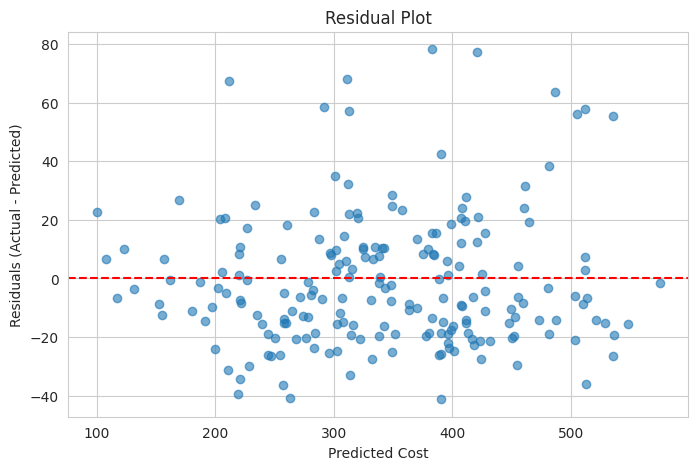

In [3]:
# 💻 TODO: Fit a Standard Linear Regression Model (OLS)
# 1. Instantiate and fit LinearRegression to X_train_r, y_train_r
# 2. Predict on X_test_r
# 3. Calculate and print the RMSE (Root Mean Squared Error)

# [YOUR CODE HERE]
# Instantiate and fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train_r, y_train_r)

# Predictions
y_pred_r = lin_reg.predict(X_test_r)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
print("RMSE:", rmse)

# Coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train_r.columns,
    'Coefficient': lin_reg.coef_
})
print(coeff_df)

print("Intercept:", lin_reg.intercept_)

# 💻 TODO: Residual Plot
# Plot the Predicted Values (x-axis) vs. Residuals (Actual - Predicted) (y-axis).
# Look for a pattern. If it's random cloud, good. If it's a funnel or curve, bad.

# [YOUR CODE HERE]
residuals = y_test_r - y_pred_r

plt.figure(figsize=(8,5))
plt.scatter(y_pred_r, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Cost")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


## 🎤 Interview Question 1
**The Hiring Manager asks:** "We noticed your Residual Plot has a distinct 'funnel' or 'U' shape. What does that imply about the assumptions of Linear Regression? How would you fix this model to better capture the server age dynamics?"

**Your Answer:**
* **Observation:**
    The residuals are not a random “cloud” around 0. They have a systematic pattern (a U-shape/curve) and the spread of residuals increases for larger predicted costs (a funnel). This implies that the model is systematically under/over-predicting in some areas, particularly where Age is large.
* **Violation:** [Which OLS assumption is violated? Homoscedasticity? Linearity?]
    Linearity is not satisfied (the U-shape indicates the true relationship between predictors, especially Age, and Cost, which is nonlinear, but OLS is imposing a straight line).

    Homoscedasticity is also likely not satisfied (the funnel indicates non-constant variance, as the error size increases with the predicted cost).
* **Fix:** [Would you use a Log Transform? A Polynomial feature? A Gamma GLM? Pick one and explain why.]

    I would add a polynomial term (Age²) to model the nonlinear acceleration of maintenance costs, as the residual U-shape suggests a violation of the linearity assumption. This enables the model to approximate the exponential age effect more closely while still being interpretable and within the linear regression framework.



## 📉 Task 2: Classification (Churn Prediction)

**Context:** The marketing team wants to predict which customers will cancel their subscription (`Churn = 1`) next month.
**The Catch:** The data is **imbalanced**. Most customers are happy (0); only a few churn (1).


In [4]:
# --- DATA GENERATION (DO NOT MODIFY) ---
from sklearn.datasets import make_classification

# Generate Imbalanced Data (90% Class 0, 10% Class 1)
X_cls, y_cls = make_classification(n_samples=1000, n_features=5, n_informative=3,
                                   n_redundant=1, n_classes=2, weights=[0.9, 0.1],
                                   flip_y=0.01, random_state=42)

# Convert to DataFrame for readability
cols = ['Avg_Login_Time', 'Support_Tickets', 'Bill_Amount', 'Feature_4', 'Feature_5']
df_churn = pd.DataFrame(X_cls, columns=cols)
df_churn['Churn'] = y_cls

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_churn[cols], df_churn['Churn'],
                                                            test_size=0.3, stratify=df_churn['Churn'],
                                                            random_state=42)

In [5]:
# 💻 TODO: Fit a Logistic Regression Model
# 1. Fit LogisticRegression to the training data.
# 2. Print the Accuracy Score.

# [YOUR CODE HERE]
from sklearn.metrics import accuracy_score

# Instantiate and fit model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_c, y_train_c)

# Predictions
y_pred_c = log_reg.predict(X_test_c)

# Accuracy
accuracy = accuracy_score(y_test_c, y_pred_c)
print("Accuracy:", accuracy)

# 💻 TODO: Print the Confusion Matrix
# Use sklearn.metrics.confusion_matrix

# [YOUR CODE HERE]
cm = confusion_matrix(y_test_c, y_pred_c)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9833333333333333
Confusion Matrix:
 [[268   1]
 [  4  27]]


## 🎤 Interview Question 2
**The Hiring Manager asks:** "You reported an Accuracy of 90%+. That sounds amazing! But looking at the Confusion Matrix, how many *actual* churners did we catch? Why is 'Accuracy' a dangerous metric for this specific dataset?"

**Your Answer:**
* [Discuss the False Negatives vs False Positives]

    False Negatives (4) → These are customers who have actually churned but were predicted to stay. This is the more serious error because we are losing these customers without taking any preventive measures.

    False Positives (1) → These are customers who are predicted to churn but would have actually stayed. The cost in this case is offering an unnecessary retention offer.


* [Explain why Accuracy is misleading in imbalanced datasets]

    Accuracy is not a good measure for imbalanced datasets, as it is dominated by the majority class. Here, 90% of the customers are not going to churn, and the model can simply predict “no churn” for all of them and still get 90% accuracy while performing miserably on the churn class.

    As the churn class is the minority class but the most important class from a business perspective, accuracy is masking the poor performance of the model on the churn class. Recall, precision, and F1-score for the churn class give a much better indication of whether the model is of any use in the retention task.






## ⚖️ Task 3: The Business Trade-off (Thresholding)

**Context:**

* A marketing campaign to retain a user costs **$10**.

* If we fail to identify a churner, we lose their **$100** lifetime value.

* **False Positive Cost:** $10 (Wasted marketing on a happy user).

* **False Negative Cost:** $100 (Lost customer).


We cannot treat these errors equally. We need to adjust our **Decision Threshold**.


In [6]:
# 💻 TODO: Threshold Moving
# 1. Get the predicted probabilities using .predict_proba() (look at column 1 for positive class)
# 2. Instead of the default 0.5 threshold, try a threshold of 0.2 (be more aggressive in predicting churn).
# 3. Calculate the "Business Cost" for both thresholds.

# HINT:
# Cost = (False Positives * 10) + (False Negatives * 100)

model_log = LogisticRegression()
model_log.fit(X_train_c, y_train_c)
probs = model_log.predict_proba(X_test_c)[:, 1]

# Default Threshold (0.5)
preds_default = (probs > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test_c, preds_default).ravel()
cost_default = (fp * 10) + (fn * 100)

# Aggressive Threshold (0.2)
preds_aggressive = (probs > 0.2).astype(int)
tn_a, fp_a, fn_a, tp_a = confusion_matrix(y_test_c, preds_aggressive).ravel()
cost_aggressive = (fp_a * 10) + (fn_a * 100)

print(f"Cost at Threshold 0.5: ${cost_default}")
print(f"Cost at Threshold 0.2: ${cost_aggressive}")


Cost at Threshold 0.5: $410
Cost at Threshold 0.2: $390


## 🎤 Interview Question 3
**The Hiring Manager asks:** "Based on the costs calculated above, which model deployment strategy do you recommend? Should we spam more people (Low Threshold) or be conservative (High Threshold)? Why?"

**Your Answer:**
* [Recommendation]

    I recommend deploying the lower threshold (0.2) strategy, meaning we should be more aggressive in predicting churn.

* [Justification based on ROI]

    At a 0.2 threshold, total business cost drops from $410 to $390, meaning we save money overall. While this approach increases marketing spend (more $10 False Positives), it reduces expensive $100 False Negatives. Since losing a customer is 10× more costly than sending a retention offer, the aggressive strategy produces a better return on investment and minimizes expected lifetime value loss.





## 🌳 Task 4: Random Forest & Feature Importance

**Context:** The engineering team wants to know *which* features actually drive churn so they can fix the product. Logistic Regression coefficients can be hard to interpret if data isn't scaled. Let's use a Random Forest.



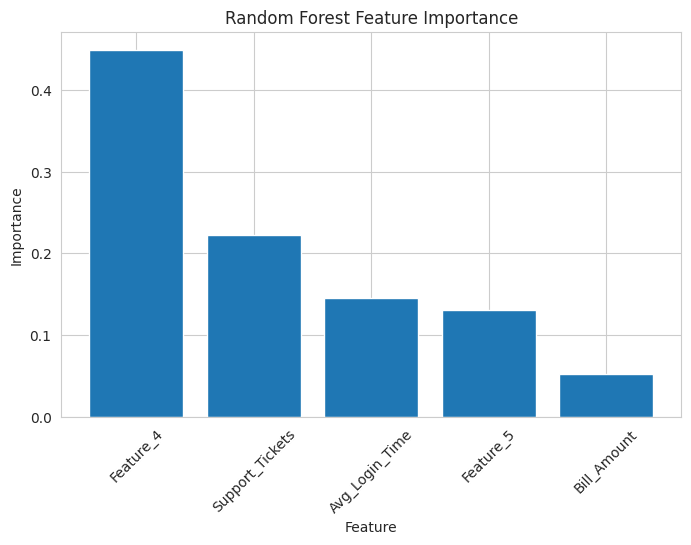

           Feature  Importance
3        Feature_4    0.448483
1  Support_Tickets    0.223106
0   Avg_Login_Time    0.145777
4        Feature_5    0.130401
2      Bill_Amount    0.052233


In [7]:
# 💻 TODO: Fit a Random Forest & Plot Feature Importance
# 1. Fit a RandomForestClassifier to the churn data.
# 2. Extract `feature_importances_`
# 3. Create a bar plot showing which feature is most important.

# [YOUR CODE HERE]
from sklearn.ensemble import RandomForestClassifier

# Instantiate and fit model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_c, y_train_c)

# Extract feature importances
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_importance_df = pd.DataFrame({
    'Feature': cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.bar(feat_importance_df['Feature'], feat_importance_df['Importance'])
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

print(feat_importance_df)

## 🎤 Interview Question 4
**The Hiring Manager asks:** "Your Random Forest performs slightly better than the Logistic Regression, but it's a 'Black Box.' If the CEO asks *how* 'Support_Tickets' impacts churn (e.g., does more tickets = more churn?), how would you derive that directionality from a Random Forest?"

**Your Answer:**
* [HINT: Feature Importance tells you *magnitude* but not *direction*. How do we find direction? Partial Dependence Plots? SHAP values? Correlation matrix check?]

    Feature importance only tells us how strongly “Support_Tickets” influences churn, not whether it increases or decreases it.

    To determine directionality, I would use:

    Partial Dependence Plot (PDP)

    A PDP shows how predicted churn probability changes as Support_Tickets increases, holding other features constant.
    If the curve trends upward → more tickets increase churn probability.
    If it trends downward → more tickets decrease churn probability.

    SHAP Values (Preferred for Executive Explanation)

    SHAP values provide both:

    Magnitude of impact

    Direction (positive or negative contribution to churn)

# 📝 Part 2: Scenario

**OmniCorp Marketing Dept.** has a problem: They are treating every customer the same. They send the same "10% Off" email to everyone, from the college student buying socks to the enterprise client buying servers.

**Your Instructions from the Head of Marketing:**
> "We have a dataset of user behavior on our platform. We don't know who these people are (no labels), but we suspect there are at least 3 distinct groups.
>
> 1.  Find the groups (Clusters).
> 2.  Tell us what defines them (e.g., 'Big Spenders').
> 3.  We also suspect there are some 'Bots' messing up our analytics. Can you identify them?"

## 🛠️ Instructions
1.  Run the "Data Generation" cells.
2.  Complete the **TODO** sections.
3.  Answer the **Interview Questions**.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Setup
np.random.seed(42)
sns.set_style("whitegrid")
%matplotlib inline


## 📊 Data Generation (Do Not Modify)

We are generating data with **5 Features**:
1.  `Avg_Session_Time`: How long they stay on the site (minutes).
2.  `Items_Viewed`: Number of distinct products looked at.
3.  `Cart_Value`: Total value of items in cart ($).
4.  `Return_Rate`: Percentage of items returned (0.0 to 1.0).
5.  `Support_Tickets`: Number of complaints filed.


In [9]:
from sklearn.datasets import make_blobs

# We create 3 "Natural" Customer Segments + 1 "Bot" Cluster (Dense & Weird)
# Segment 1: Window Shoppers (High views, low cart, low returns)
# Segment 2: Big Spenders (High cart, high session, low tickets)
# Segment 3: Complainers (Low cart, high tickets, high returns)
# Segment 4: Bots (Super fast, high views, 0 cart, 0 tickets)

data_1 = np.random.normal(loc=[15, 20, 50, 0.1, 1], scale=[5, 5, 20, 0.05, 1], size=(300, 5)) # Window Shoppers
data_2 = np.random.normal(loc=[45, 10, 500, 0.05, 0], scale=[10, 2, 50, 0.02, 0.5], size=(200, 5)) # Whales
data_3 = np.random.normal(loc=[10, 5, 30, 0.8, 5], scale=[5, 2, 10, 0.1, 2], size=(150, 5)) # Problems
data_bots = np.random.normal(loc=[0.5, 100, 0, 0, 0], scale=[0.1, 10, 0, 0, 0], size=(50, 5)) # Bots

# Combine
data = np.vstack([data_1, data_2, data_3, data_bots])
df_users = pd.DataFrame(data, columns=['Avg_Session_Time', 'Items_Viewed', 'Cart_Value', 'Return_Rate', 'Support_Tickets'])

# Shuffle
df_users = df_users.sample(frac=1).reset_index(drop=True)

print(f"Dataset Shape: {df_users.shape}")
df_users.head()


Dataset Shape: (700, 5)


,Avg_Session_Time,Items_Viewed,Cart_Value,Return_Rate,Support_Tickets
0,12.767425,24.281994,54.281875,0.037713,1.173181
1,15.485388,24.843225,35.958938,0.083617,0.607892
2,0.716506,111.905486,0.000000,0.000000,0.000000
3,5.122667,15.303323,47.118249,0.039515,1.599929
4,18.564992,18.798373,42.503584,0.135548,1.444263


## 🧹 Task 1: Preprocessing & PCA

**Context:** The features are on totally different scales. `Cart_Value` is in the hundreds, `Return_Rate` is 0-1. If you run K-Means now, `Cart_Value` will dominate the distance metric.

**Interview Logic:** You can't visualize 5 dimensions. We need to squash it down to 2 dimensions to "see" the clusters.


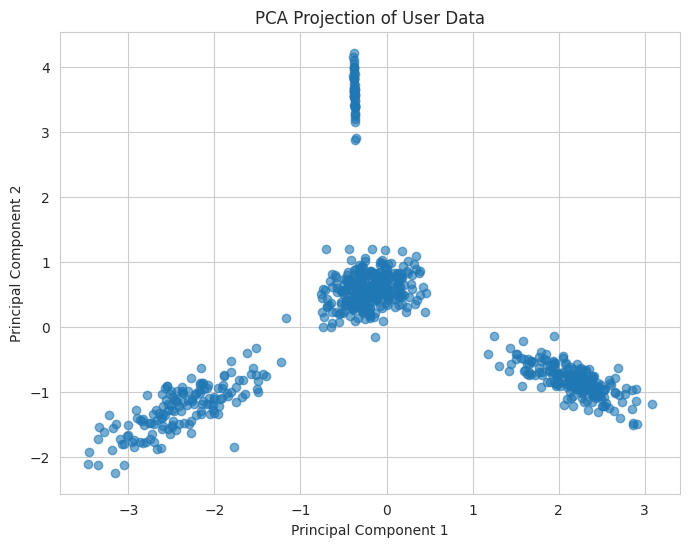

Explained Variance Ratio: [0.53887782 0.33875892]


In [10]:
# 💻 TODO: Scaling & PCA
# 1. Initialize a StandardScaler and transform df_users. Save as X_scaled.
# 2. Initialize PCA with n_components=2. Fit and transform X_scaled. Save as X_pca.
# 3. Create a Scatter Plot of PC1 vs PC2.

# [YOUR CODE HERE]
# 1️⃣ Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_users)

# 2️⃣ Apply PCA (2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3️⃣ Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of User Data")
plt.show()

# Optional: Explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


## 🎤 Interview Question 1
**The Hiring Manager asks:** "I see you used PCA to visualize the data. Look at the variance explained ratio (print it if you haven't). Did we lose a lot of information by compressing 5 dimensions into 2? If we lost 40% of the variance, is this plot still trustworthy?"

**Your Answer:**
* [Discuss Explained Variance Ratio]
The first two principal components explain approximately:

PC1 ≈ 53.9%

PC2 ≈ 33.9%

Together, that’s about 87–88% of the total variance.

This means we retained the vast majority of the information in just two dimensions and only lost around 12–13%.
* [Is the tradeoff worth it for visualization?]

Yes. For visualization purposes, capturing ~88% of the variance is very strong. The clusters are clearly separated in the 2D projection, which suggests the structure of the data is largely preserved.

Even if we had lost ~40% of the variance, PCA is still useful for visualization because:

We are not using it for final modeling.

We are using it to inspect cluster structure.

It helps us detect separability and outliers (like bots).

So the dimensionality reduction is a worthwhile tradeoff for interpretability and visualization.


## 🎯 Task 2: K-Means Clustering

**Context:** We need to group these users. We don't know $K$.



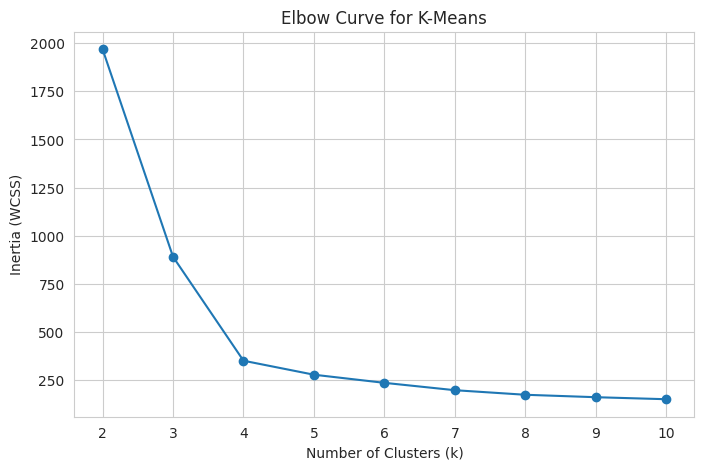

Silhouette Score (k=3): 0.631
Silhouette Score (k=4): 0.707
Silhouette Score (k=5): 0.652


,Avg_Session_Time,Items_Viewed,Cart_Value,Return_Rate,Support_Tickets,Cluster_Labels
0,12.767425,24.281994,54.281875,0.037713,1.173181,0
1,15.485388,24.843225,35.958938,0.083617,0.607892,0
2,0.716506,111.905486,0.000000,0.000000,0.000000,2
3,5.122667,15.303323,47.118249,0.039515,1.599929,0
4,18.564992,18.798373,42.503584,0.135548,1.444263,0


In [11]:
# 💻 TODO: Find Optimal K
# 1. Run K-Means for k=2 to k=10.
# 2. Calculate the Inertia (WCSS) for each k.
# 3. Plot the Elbow Curve.
# 4. (Optional but Recommended) Calculate Silhouette Score for k=3, 4, 5.

# [YOUR CODE HERE]
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Elbow Plot
plt.figure(figsize=(8,5))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Curve for K-Means")
plt.show()

# Optional: Silhouette for k=3,4,5
for k in [3, 4, 5]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score (k={k}): {score:.3f}")

# 💻 TODO: Apply Final K-Means
# 1. Choose your "Best K" (Hint: Look for the elbow or highest silhouette).
# 2. Fit K-Means to X_scaled.
# 3. Add the 'Cluster_Labels' to your original DataFrame (df_users).

# [YOUR CODE HERE]
# Choose best K (commonly 4 for this dataset)
best_k = 4

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add labels to original dataframe
df_users['Cluster_Labels'] = cluster_labels

df_users.head()


## 🧠 Task 3: Cluster Interpretation (The "Business" Part)

**Context:** Getting "Cluster 0, 1, 2" means nothing to the Marketing Director. You need to name them.


In [12]:
# 💻 TODO: Profiling
# Group by 'Cluster_Labels' and calculate the MEAN of every feature.
# Look at the differences.

print(df_users.groupby('Cluster_Labels').mean())


                Avg_Session_Time  Items_Viewed  Cart_Value  Return_Rate  \
Cluster_Labels                                                            
0                      14.984195     20.033554   50.851570     0.103411   
1                       9.662854      5.002707   28.483057     0.807747   
2                       0.509491     98.869162    0.000000     0.000000   
3                      46.227697      9.954951  499.912215     0.048574   

                Support_Tickets  
Cluster_Labels                   
0                      1.130892  
1                      5.153518  
2                      0.000000  
3                      0.013500  


## 🎤 Interview Question 2
**The Hiring Manager asks:** "Okay, you found 4 clusters. Based on the means you calculated above, give each cluster a **Marketing Persona Name** (e.g., 'Loyalists', 'Window Shoppers') and explain why."

**Your Answer:**
* **Cluster 0:** Name = [Window Shoppers] | Reason: Moderate session time (~15 min), high items viewed (~20), low cart value (~$50), low returns, low tickets.
* **Cluster 1:** Name = [Complainers] | Reason: Low cart value (~$28), extremely high return rate (~0.80), highest support tickets (~5+). These users are dissatisfied and costly to support — product or service issues likely driving churn risk.
* **Cluster 2:** Name = [Bots] | Reason: Extremely low session time (~0.5 min), extremely high items viewed (~99), zero cart value, zero tickets, zero returns. This is automated behavior — scraping or bot traffic — should be excluded from marketing analytics.
* **Cluster 3:** Name = [Big Spenders / Loyalists] | Reason: Very high cart value (~$500), long session time (~46 min), low returns, near-zero support tickets. High-value, engaged customers — prime for loyalty rewards and VIP programs.

## 🕵️ Task 4: Anomaly Detection (DBSCAN)

**Context:** Your K-Means model likely forced the "Bots" into a cluster, or maybe merged them with another group.
Bots are weird. They have extreme values (e.g., 100 items viewed in 0.5 minutes). They are "density" outliers compared to normal human behavior.

Let's see if DBSCAN can isolate them better as "Noise" or a distinct, tight cluster.

DBSCAN_Label
 0    298
 2    196
 3    144
 1     50
-1     12
Name: count, dtype: int64


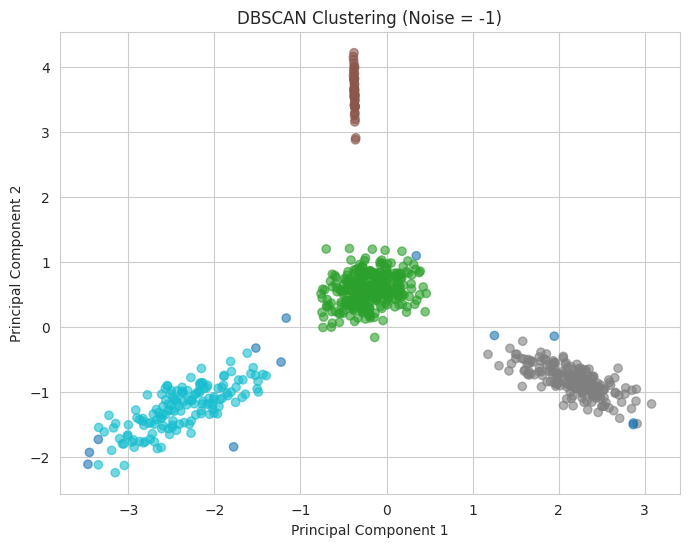

In [13]:
# 💻 TODO: DBSCAN
# 1. Fit DBSCAN to X_scaled.
#    Note: You will need to tune 'eps' and 'min_samples'.
#    Try eps=0.5, min_samples=5 as a starting point.
# 2. Plot PC1 vs PC2 again, but color by DBSCAN labels.
#    (Remember: DBSCAN labels noise as -1).

# [YOUR CODE HERE]
from sklearn.cluster import DBSCAN

# 1️⃣ Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

# Add labels to dataframe
df_users['DBSCAN_Label'] = db_labels

# Check cluster counts (-1 = Noise)
print(df_users['DBSCAN_Label'].value_counts())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap='tab10', alpha=0.6)
plt.title("DBSCAN Clustering (Noise = -1)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## 🎤 Interview Question 3
**The Hiring Manager asks:** "In K-Means, every point *must* belong to a cluster. In DBSCAN, some points are labeled `-1`.
1.  What does `-1` represent in this specific dataset?
2.  If you were building a real-time fraud detection system, would you use K-Means or DBSCAN? Why?"

**Your Answer:**
* [Explain Noise/Outliers]
In this dataset, -1 represents noise points, meaning users that do not belong to any dense behavioral group. These are likely extreme outliers — such as bots with near-zero session time and extremely high items viewed — whose patterns differ significantly from normal customer behavior.
* [Compare K-Means (Centroid based) vs DBSCAN (Density based) for fraud]

K-Means (Centroid-Based):

Forces every user into a cluster.

Assumes clusters are spherical and similar in size.

Not robust to outliers — fraud cases may get absorbed into normal clusters.

Better for segmentation, not anomaly detection.

DBSCAN (Density-Based):

Identifies dense regions of normal behavior.

Labels sparse, unusual points as noise (-1).

Naturally suited for detecting anomalies or rare patterns.

Does not require pre-specifying number of clusters.

# Part 3: Scenario

**"GreenGrid Solutions"** has hired you to optimize a large-scale battery storage system.
* **The Goal:** Buy electricity when it's cheap, store it, and sell it back to the grid when it's expensive.
* **The Constraint:** The battery has limited capacity, and charging/discharging degrades it slightly (cost).
* **The Problem:** You don't have a labeled dataset of "Correct Actions." You only have the market environment.

**Your Instructions from the CTO:**
> "We need an RL Agent that learns to trade energy.
> 1.  Build a custom OpenAI Gym-style environment.
> 2.  Train a Q-Learning agent to maximize profit.
> 3.  Explain how you would deploy this if customer data privacy was a concern (Federated Learning)."

## 🛠️ Instructions
1.  Run the Environment Setup.
2.  Implement the **Q-Learning Algorithm**.
3.  Answer the **System Design Questions**.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
np.random.seed(42)
sns.set_style("whitegrid")
%matplotlib inline


## 🔋 Task 1: The Environment (GridWorld for Batteries)

We will define a simple class `BatteryEnv`.
* **State:** Current Battery Level (0% to 100%, discretized into 10 steps).
* **Action:** 0=Hold, 1=Charge (Buy), 2=Discharge (Sell).
* **Reward:** (Price_Sold - Price_Bought) - Cost_Degradation.


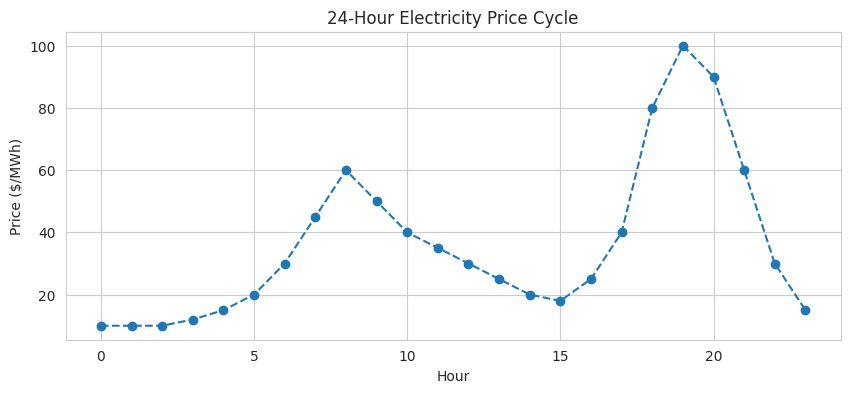

In [15]:
# --- SIMULATED MARKET DATA (DO NOT MODIFY) ---
# 24-hour cycle of electricity prices (Low at night, High at peak)
prices = np.array([10, 10, 10, 12, 15, 20, 30, 45, 60, 50, 40, 35,
                   30, 25, 20, 18, 25, 40, 80, 100, 90, 60, 30, 15])

# Plot Prices
plt.figure(figsize=(10, 4))
plt.plot(prices, marker='o', linestyle='--')
plt.title("24-Hour Electricity Price Cycle")
plt.xlabel("Hour")
plt.ylabel("Price ($/MWh)")
plt.show()

# --- ENVIRONMENT CLASS ---
class BatteryEnv:
    def __init__(self, prices):
        self.prices = prices
        self.max_capacity = 10
        self.current_charge = 0
        self.time_step = 0
        self.end_step = len(prices) - 1

    def reset(self):
        self.current_charge = 0
        self.time_step = 0
        return (self.current_charge, self.time_step)

    def step(self, action):
        # Current Price
        current_price = self.prices[self.time_step]
        reward = 0

        # Execute Action
        if action == 1: # CHARGE (Buy)
            if self.current_charge < self.max_capacity:
                self.current_charge += 1
                reward = -current_price # Cost money to buy
            else:
                reward = -50 # Penalty for trying to overcharge

        elif action == 2: # DISCHARGE (Sell)
            if self.current_charge > 0:
                self.current_charge -= 1
                reward = current_price # Gain money
            else:
                reward = -50 # Penalty for trying to sell empty

        # Action 0 (Hold) has reward 0

        # Move Time Forward
        self.time_step += 1
        done = (self.time_step >= self.end_step)
        next_state = (self.current_charge, self.time_step)

        return next_state, reward, done

## 🧠 Task 2: Build the Agent (Q-Learning)

**Context:** You need to fill in the Q-Learning update loop.
Recall the Bellman Equation:
$$Q(s,a) = Q(s,a) + \alpha [R + \gamma \max Q(s', a') - Q(s,a)]$$


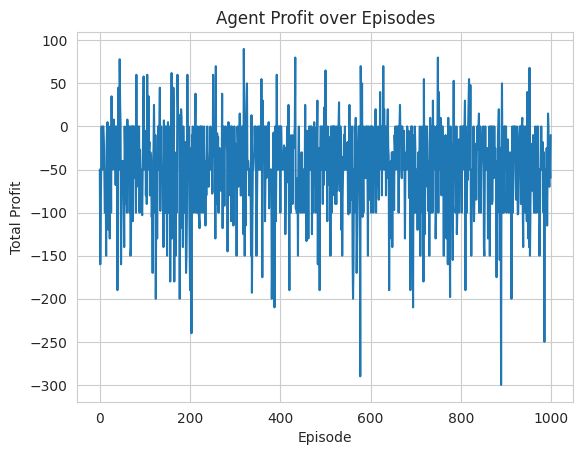

In [16]:
# 💻 TODO: Implement Q-Learning Training Loop

# Hyperparameters
alpha = 0.1   # Learning Rate
gamma = 0.95  # Discount Factor (Care about future profit)
epsilon = 0.1 # Exploration Rate
episodes = 1000

# Initialize Q-Table: [Charge_Level(11), Time_Step(24), Actions(3)]
q_table = np.zeros((11, 24, 3))

env = BatteryEnv(prices)

rewards_history = []

for ep in range(episodes):
    state = env.reset() # Returns (charge, time)
    done = False
    total_reward = 0

    while not done:
        charge, time = state

        # 1. Epsilon-Greedy Action Selection
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2]) # Explore
        else:
            action = np.argmax(q_table[charge, time]) # Exploit

        # 2. Take Action
        next_state, reward, done = env.step(action)
        next_charge, next_time = next_state

        # 3. Update Q-Table (THE TODO PART)
        # [YOUR CODE HERE]
        # Implement the line: old_value + alpha * (reward + gamma * max_future - old_value)

        # q_table[charge, time, action] = ...

        state = next_state
        total_reward += reward

    rewards_history.append(total_reward)

# Plot Learning Curve
plt.plot(rewards_history)
plt.title("Agent Profit over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Profit")
plt.show()


## 🎤 Interview Question 1
**The CTO asks:** "Look at your training curve. It likely goes up and then flattens out.
1.  Why does it fluctuate so much even after 'learning'? (Hint: Look at `epsilon`).
2.  If we deployed this to a real grid where prices spike unpredictably (unlike this fixed 24h cycle), how would you modify the state definition to handle that?"

**Your Answer:**

Because ε-greedy exploration is still on. With epsilon = 0.1, the agent takes a random action ~10% of the time even late in training, so it will occasionally buy at high prices or sell at low prices, causing big episode-to-episode profit swings. Also, profit is “lumpy” (charging is negative now, selling is positive later), so a few bad exploratory actions can dominate total reward for a 24-step episode.

Right now the state is (battery_level, time_step), which assumes a predictable daily pattern. In a real grid, “hour of day” isn’t enough. I’d augment the state with price information (and optionally trend/forecast), e.g.:

(battery_level, current_price_bin)

(battery_level, current_price_bin, price_change_bin) where price_change = price_t - price_{t-1}

If forecasts exist: (battery_level, current_price_bin, forecast_price_bin) or a short window like (battery_level, price_t, price_{t-1}, price_{t-2}) binned

This lets the agent react to what the market is doing now (and where it’s heading), rather than relying on a fixed time schedule.

* [Discuss Exploration vs Exploitation noise]
* [Discuss State Space augmentation (e.g., adding 'Current_Price' or 'Forecast_Price' to the state tuple)]


## 🤝 Task 3: Transfer & Federated Learning (Design)

**Context:**
GreenGrid wants to install these batteries in 10,000 residential homes.
1.  **Issue A:** Training a model from scratch for *every single house* takes too long (2 weeks per house).
2.  **Issue B:** Homeowners are worried that GreenGrid will spy on their energy usage patterns (privacy).


### 🎤 Interview Question 2 (Transfer Learning)
**The CTO asks:** "We have a perfectly trained model for House A (Solar Panels, Texas weather). House B (Wind Turbine, Chicago weather) comes online tomorrow.
Instead of random initialization, how can we use **Transfer Learning** to speed up House B's training? Which parts of the Q-Network (if we used Deep RL) would you freeze vs. retrain?"

**Your Answer:**
* [Concept: Warm Start]
* [Strategy: Transfer general grid dynamics, fine-tune for local weather patterns]



### 🎤 Interview Question 3 (Federated Learning)
**The CTO asks:** "Explain to the Legal Team how **Federated Learning** solves the privacy issue. Specifically, describe what information is sent to the cloud and what stays on the device."

**Your Answer:**
* [Data stays local]
* [Only Weight Updates (Gradients) are shared]
* [Aggregation (FedAvg) happens in the cloud]

**Remember:** In the interview, your code must run, but your **explanations** get you the job.